<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/Combined_Regression_Classification_CTCF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import division, print_function

In [2]:
!pip uninstall momma_dragonn
!git clone https://github.com/kundajelab/momma_dragonn
!pip install ./momma_dragonn
!rm -rf momma_dragonn

Skipping momma-dragonn as it is not installed.
Cloning into 'momma_dragonn'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 1804 (delta 30), reused 21 (delta 10), pack-reused 1756
Receiving objects: 100% (1804/1804), 12.29 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (1185/1185), done.
Processing ./momma_dragonn
  Running setup.py bdist_wheel for momma-dragonn ... - \ done
  Stored in directory: /tmp/pip-ephem-wheel-cache-pjwzkiq9/wheels/1f/3d/02/806b6787ce8ec1b13ac41dc8ae024f34874d46b8db7b487319
  Running setup.py bdist_wheel for avutils ... - done
  Stored in directory: /root/.cache/pip/wheels/c2/10/60/224c0029355b3627d218534df8cbf15588409cdd6bc8df0993
Successfully built momma-dragonn avutils


In [3]:
!pip install pyfasta
!pip install deeptools
!git clone https://github.com/kundajelab/momma_dragonn
!pip install ./momma_dragonn
!rm -rf momma_dragonn

!apt-get install bedtools

#Download optimal IDR thresholded peaks
![[ -f idr_optimal_file.narrowPeak.gz ]] || wget https://www.encodeproject.org/files/ENCFF519CXF/@@download/ENCFF519CXF.bed.gz -O idr_optimal_file.narrowPeak.gz
  
#Get hg38 fasta by download 2bit and then converting to fa
![[ -f hg38.2bit ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.2bit -O hg38.2bit  
![[ -f twoBitToFa ]] || wget http://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/twoBitToFa -O twoBitToFa
!chmod a+x twoBitToFa
![[ -f hg38.genome.fa ]] || ./twoBitToFa hg38.2bit hg38.genome.fa
  
#download hg38 chromsizes file
![[ -f hg38.chrom.sizes ]] || wget http://hgdownload.cse.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O hg38.chrom.sizes

  Running setup.py bdist_wheel for pyfasta ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/ef/57/33/7b569168243dfbfe60bd3533e6897d170b391f2ce58df9d275
Successfully built pyfasta
    100% |████████████████████████████████| 3.3MB 10.3MB/s 
    100% |████████████████████████████████| 9.7MB 1.1MB/s 
    100% |████████████████████████████████| 71kB 24.2MB/s 
    100% |████████████████████████████████| 37.8MB 909kB/s 
    100% |████████████████████████████████| 3.1MB 12.3MB/s 
    100% |████████████████████████████████| 552kB 23.4MB/s 
    100% |████████████████████████████████| 71kB 25.5MB/s 
    100% |████████████████████████████████| 8.1MB 5.1MB/s 
  Running setup.py bdist_wheel for deeptools ... - \ | / - \ | / - done
  Stored in directory: /root/.cache/pip/wheels/26/7b/1a/e828c248cbb05db00a41118e24c0435bcdbf1b750f4dd2c0c8
  Running setup.py bdist_wheel for numpydoc ... - done
  Stored in directory: /root/.cache/pip/wheels/ea/55/7f/3e25d754760ccd62

In [4]:
#do an asinh transform of column 7 (SPP singal strength)
!zcat idr_optimal_file.narrowPeak.gz | perl -lane 'BEGIN{use Math::Trig} {print $F[0]."\t".(($F[1]+$F[9]))."\t".(($F[1]+$F[9]))."\t".asinh($F[6])}' | bedtools slop -g hg38.chrom.sizes -b 500 | perl -lane 'if ($F[2]-$F[1]==1000) {print $F[0]."\t".$F[1]."\t".$F[2]."\t1\t$F[3]"}' | sortBed | gzip -c > positives_hybridbnc_asinh_spp.gz

import os
import sys
import gzip
from collections import OrderedDict

def tile_across_genome(chrom_sizes_file,
                       chroms_to_exclude,
                       out_file, bin_sizes,
                       bin_stride):

    chromosome_sizes = OrderedDict()
    for line in open(chrom_sizes_file):
        chrom, size = line.rstrip().split("\t")
        if (("_" not in chrom) and
            (chrom not in chroms_to_exclude)):
            size = int(size)
            chromosome_sizes[chrom] = size 
        else:
            pass
            #print("Dropping chrom",chrom)

    outfile = open(out_file, "w")
    
    for a_chrom in chromosome_sizes:
        the_end = chromosome_sizes[a_chrom] 
        bin_start = 0
        while ((bin_start + bin_sizes) < the_end):
            outfile.write(a_chrom+"\t"+str(bin_start)
                          +"\t"+str(bin_start+bin_sizes)+"\n")
            bin_start += bin_stride

    outfile.close()

if (os.path.isfile("1kb_tiles.bed")==False):
  print("Tiling across the genome in 1kb windows")
  tile_across_genome(out_file = "1kb_tiles.bed",
                     chrom_sizes_file="hg38.chrom.sizes",
                     bin_sizes=1000,
                     bin_stride=1000,
                     chroms_to_exclude=["chrM"])    

  
# Negative set: 1kb regions tiling across the genome that do not overlap any of the peaks in the idr file
!bedtools intersect -sorted -v -a 1kb_tiles.bed -b positives_hybridbnc_asinh_spp.gz -wa | perl -lane 'print $F[0]."\t".$F[1]."\t".$F[2]."\t0\t0"' | gzip -c > negative_regions.gz
!zcat positives_hybridbnc_asinh_spp.gz negative_regions.gz | sortBed | gzip -c > hybridbnc_asinh_spp_labels.gz

#train-test-valid splits
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_hybridbnc_asinh_spp_labels.gz
!zcat test_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_test_hybridbnc_asinh_spp_labels.gz
!zcat test_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_test_hybridbnc_asinh_spp_labels.gz
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w 'chr22' | gzip -c > valid_hybridbnc_asinh_spp_labels.gz
!zcat valid_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_valid_hybridbnc_asinh_spp_labels.gz
!zcat valid_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_valid_hybridbnc_asinh_spp_labels.gz
!zcat hybridbnc_asinh_spp_labels.gz | egrep -w -v 'chr1|chr8|chr21|chr22' | gzip -c > train_hybridbnc_asinh_spp_labels.gz
!zcat train_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==1) {print $_}' | gzip -c > positives_train_hybridbnc_asinh_spp_labels.gz
!zcat train_hybridbnc_asinh_spp_labels.gz | perl -lane 'if ($F[3]==0) {print $_}' | gzip -c > negatives_train_hybridbnc_asinh_spp_labels.gz


Tiling across the genome in 1kb windows


In [5]:
!pip uninstall keras-genomics
!git clone https://github.com/kundajelab/keras-genomics
!pip install ./keras-genomics
!rm -rf keras-genomics

import keras_genomics
import importlib
importlib.reload(keras_genomics.layers.core)
importlib.reload(keras_genomics.layers)
importlib.reload(keras_genomics)

Skipping keras-genomics as it is not installed.
Cloning into 'keras-genomics'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 145 (delta 32), reused 19 (delta 10), pack-reused 88
Receiving objects: 100% (145/145), 42.36 KiB | 8.47 MiB/s, done.
Resolving deltas: 100% (65/65), done.
Processing ./keras-genomics
  Running setup.py bdist_wheel for keras-genomics ... - done
  Stored in directory: /root/.cache/pip/wheels/05/33/43/86625fb5b8c2ee622e87e8c69bfa1c5050350276cfea876a3a
Successfully built keras-genomics


Using TensorFlow backend.


<module 'keras_genomics' from '/usr/local/lib/python3.6/dist-packages/keras_genomics/__init__.py'>

In [0]:
import keras
from keras.models import Model
from momma_dragonn.data_loaders import pyfasta_data_loader
import six
from scipy.stats import spearmanr
import numpy as np
import keras_genomics
from keras_genomics.layers.core import SeparableFC

class SpearmanCorrCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps,
                       valid_data_generator,
                       idx_to_look_at=0):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
      self.idx_to_look_at = idx_to_look_at
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print(spearmanr(a=valid_data_labels[:,self.idx_to_look_at],
                      b=valid_data_preds[:,self.idx_to_look_at]))

def get_single_stream_data_generator(**kwargs):

  return pyfasta_data_loader.SingleStreamSeqOnly(
               fasta_data_source="hg38.genome.fa",
               rc_augment=True,
               num_to_load_for_eval=100, #not used
               labels_dtype="float",
               wrap_in_keys=["sequence", "output"],
               randomize_after_pass=True,
               **kwargs)


def get_core_model(num_conv_filters,
                   conv_filter_length,
                   pool_length_and_stride):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
  conv1batchnorm = keras.layers.normalization.BatchNormalization()(conv1)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1batchnorm)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2batchnorm = keras.layers.normalization.BatchNormalization()(conv2)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2batchnorm)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3batchnorm = keras.layers.normalization.BatchNormalization()(conv3)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3batchnorm)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  #flatten = keras.layers.core.Flatten()(avgpool)
  sepfc = SeparableFC(num_conv_filters*10, symmetric=True)(avgpool)
  
  return (input, sepfc)


def train_positivesonly_regression_model(num_outputs,
                           train_bed_source,
                           train_labels_subset,
                           valid_bed_source,
                           valid_labels_subset,
                           num_validation_samples,
                           steps_per_epoch=200,
                           batch_size=128,
                           adam_lr=0.001,
                           num_conv_filters=15,
                           conv_filter_length=15,
                           pool_length_and_stride=5,
                           num_dense_units=100,
                           preinit_model=None,
                           epochs_to_train_for=60):
  
  validation_steps = int(np.ceil(num_validation_samples/batch_size))    
  
  if (preinit_model is None):
    
    (input,sepfc) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride,
        #num_dense_units=num_dense_units
    )
    
    dense1 = keras.layers.core.Dense(units=num_dense_units)(sepfc)
    dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
    dense2 = keras.layers.core.Dense(units=num_dense_units)(dense1relu)
    dense2relu = keras.layers.core.Activation(activation="relu")(dense2)
    
    skip_conn = keras.layers.Add()([dense1relu, dense2relu])
    output = keras.layers.core.Dense(units=num_outputs,
                                     name="output")(skip_conn)
    
    #outputfromdense1 = keras.layers.core.Dense(units=num_outputs,
    #                                           name="outputfromdense1")(dense1relu)
    #outputfromsepfc = keras.layers.core.Dense(units=num_outputs,
    #                                          name="outputfromsepfc")(sepfc)
    #output = keras.layers.Average(name="output")([outputfromsepfc,
    #                                              outputfromdense1])
    
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "mse"})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_single_stream_data_generator(
      bed_source=train_bed_source,
      labels_subset=train_labels_subset,
      batch_size=batch_size,
      random_seed=2).get_batch_generator(),
    validation_data= get_single_stream_data_generator(
      bed_source=valid_bed_source,
      labels_subset=valid_labels_subset,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               SpearmanCorrCallback(
                   valid_data_generator=get_single_stream_data_generator(
                      bed_source=valid_bed_source,
                      labels_subset=valid_labels_subset,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 1000, 15)     915         sequence[0][0]                   
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 1000, 15)     60          conv1d_7[0][0]                   
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 1000, 15)     0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv1d_8 (

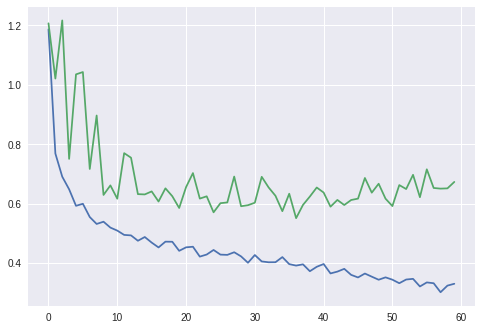

Best valid epoch: 37


'#Load the model\nfrom google.colab import drive\ndrive.mount(\'/content/gdrive\')\n%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF\npositives_asinh_spp_model = load_model("positives_asinh_spp_model_2018Nov30_0828pm_withsepfclayers.h5")\n%cd /content'

In [13]:
from matplotlib import pyplot as plt
from keras.models import load_model

positives_asinh_spp_model, positives_asinh_spp_fit_history =\
  train_positivesonly_regression_model(
       num_outputs=1,
       batch_size=64,
       num_validation_samples=sum([1 for x in gzip.open("positives_valid_hybridbnc_asinh_spp_labels.gz",'rb')]),
       train_bed_source="positives_train_hybridbnc_asinh_spp_labels.gz",
       train_labels_subset=[1],
       valid_bed_source="positives_valid_hybridbnc_asinh_spp_labels.gz",
       valid_labels_subset=[1])


from matplotlib import pyplot as plt
plt.plot(list(range(len(positives_asinh_spp_fit_history.history['loss']))),
         positives_asinh_spp_fit_history.history['loss'])
plt.plot(list(range(len(positives_asinh_spp_fit_history.history['val_loss']))),
         positives_asinh_spp_fit_history.history['val_loss'])
plt.show()
print("Best valid epoch:",np.argmin(positives_asinh_spp_fit_history.history['val_loss'])+1)

"""#Load the model
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
positives_asinh_spp_model = load_model("positives_asinh_spp_model_2018Nov30_0828pm_withsepfclayers.h5")
%cd /content"""

In [14]:
#Save the model
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
positives_asinh_spp_model.save("positives_asinh_spp_model_2018Dec05_0820pm_twodenseskipconn.h5")
%cd /content


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
/content


In [0]:
#train a normal binary prediction model
from sklearn.metrics import roc_auc_score, average_precision_score

class BinaryClassificationCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps,
                       valid_data_generator,
                       idx_to_look_at=0):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
      self.idx_to_look_at = idx_to_look_at
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print("auROC:",roc_auc_score(
                      y_true=valid_data_labels[:,self.idx_to_look_at],
                      y_score=valid_data_preds[:,self.idx_to_look_at]))
      print("auPRC:",average_precision_score(
                      y_true=valid_data_labels[:,self.idx_to_look_at],
                      y_score=valid_data_preds[:,self.idx_to_look_at]))


def get_two_stream_data_generator(**kwargs):

  return pyfasta_data_loader.TwoStreamSeqOnly(
                          fasta_data_source="hg38.genome.fa",
                          rc_augment=True,
                          num_to_load_for_eval=100, #Not used
                          randomize_after_pass=True,
                          stratification_settings=None,
                          random_seed=1,
                          labels_dtype="float",
                          wrap_in_keys=["sequence", "output"],
                          append_chrom_number=False,
                          **kwargs)

def train_binary_classification_model(
    num_outputs,
    positives_train_bed_source,
    positives_train_labels_subset,
    negatives_train_bed_source,
    negatives_train_labels_subset,
    positives_valid_bed_source,
    positives_valid_labels_subset,
    negatives_valid_bed_source,
    negatives_valid_labels_subset,
    negatives_to_positives_ratio,
    num_validation_samples,
    steps_per_epoch=200,
    batch_size=128,
    adam_lr=0.001,
    num_conv_filters=15,
    conv_filter_length=15,
    pool_length_and_stride=5,
    num_dense_units=100,
    preinit_model=None,
    epochs_to_train_for=60):
  
  
  validation_steps = int(np.ceil(num_validation_samples/batch_size))    
  
  if (preinit_model is None):
    
    (input,sepfc) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride
    )
    
    dense1 = keras.layers.core.Dense(units=num_dense_units)(sepfc)
    dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
    dense2 = keras.layers.core.Dense(units=num_dense_units)(dense1relu)
    dense2relu = keras.layers.core.Activation(activation="relu")(dense2)
    
    skip_conn = keras.layers.Add()([dense1relu, dense2relu])
    output_preact = keras.layers.core.Dense(units=num_outputs)(skip_conn)
    output = keras.layers.core.Activation(activation="sigmoid",
                                          name="output")(output_preact)
    
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": "binary_crossentropy"})
  else:
    model = preinit_model
  
  model.summary()
  
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_two_stream_data_generator(
      positives_bed_source=positives_train_bed_source,
      positives_labels_subset=positives_train_labels_subset,
      negatives_bed_source=negatives_train_bed_source,
      negatives_labels_subset=negatives_train_labels_subset,
      negatives_to_positives_ratio=negatives_to_positives_ratio,
      batch_size=batch_size).get_batch_generator(),
    validation_data=get_two_stream_data_generator(
      positives_bed_source=positives_valid_bed_source,
      positives_labels_subset=positives_valid_labels_subset,
      negatives_bed_source=negatives_valid_bed_source,
      negatives_labels_subset=negatives_valid_labels_subset,
      negatives_to_positives_ratio=negatives_to_positives_ratio,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               BinaryClassificationCallback(
                   valid_data_generator=get_two_stream_data_generator(
                      positives_bed_source=positives_valid_bed_source,
                      positives_labels_subset=positives_valid_labels_subset,
                      negatives_bed_source=negatives_valid_bed_source,
                      negatives_labels_subset=negatives_valid_labels_subset,
                      negatives_to_positives_ratio=negatives_to_positives_ratio,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

In [34]:
binary_model, binary_fit_history = train_binary_classification_model(
         adam_lr=0.001,
         num_outputs=1,
         num_validation_samples=5000,
         positives_train_bed_source="positives_train_hybridbnc_asinh_spp_labels.gz",
         positives_train_labels_subset=[0],
         negatives_train_bed_source="negatives_train_hybridbnc_asinh_spp_labels.gz",
         negatives_train_labels_subset=[0],
         positives_valid_bed_source="positives_valid_hybridbnc_asinh_spp_labels.gz",
         positives_valid_labels_subset=[0],
         negatives_valid_bed_source="negatives_valid_hybridbnc_asinh_spp_labels.gz",
         negatives_valid_labels_subset=[0],
         negatives_to_positives_ratio=1)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
sequence (InputLayer)           (None, 1000, 4)      0                                            
__________________________________________________________________________________________________
conv1d_31 (Conv1D)              (None, 1000, 15)     915         sequence[0][0]                   
__________________________________________________________________________________________________
batch_normalization_31 (BatchNo (None, 1000, 15)     60          conv1d_31[0][0]                  
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 1000, 15)     0           batch_normalization_31[0][0]     
__________________________________________________________________________________________________
conv1d_32 

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103274). Check your callbacks.
  % delta_t_median)


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.123540). Check your callbacks.
  % delta_t_median)


 15/200 [=>............................] - ETA: 8:29 - loss: 0.6119

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.130834). Check your callbacks.
  % delta_t_median)


 18/200 [=>............................] - ETA: 7:02 - loss: 0.5954

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.122180). Check your callbacks.
  % delta_t_median)


 19/200 [=>............................] - ETA: 6:40 - loss: 0.5915

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.120795). Check your callbacks.
  % delta_t_median)


 20/200 [==>...........................] - ETA: 6:20 - loss: 0.5870

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.131177). Check your callbacks.
  % delta_t_median)


 23/200 [==>...........................] - ETA: 5:29 - loss: 0.5800

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.103762). Check your callbacks.
  % delta_t_median)


 24/200 [==>...........................] - ETA: 5:15 - loss: 0.5773

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.100946). Check your callbacks.
  % delta_t_median)


 28/200 [===>..........................] - ETA: 4:29 - loss: 0.5668

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106057). Check your callbacks.
  % delta_t_median)


 30/200 [===>..........................] - ETA: 4:11 - loss: 0.5613

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.102859). Check your callbacks.
  % delta_t_median)


200/200 [==============================] - 81s 404ms/step - loss: 0.4416 - val_loss: 0.5036
Reading bed file positives_valid_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 1082rows
Reading bed file negatives_valid_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 50818rows
auROC: 0.9092654991149901
auPRC: 0.9028982719481674
Epoch 2/60
200/200 [==============================] - 35s 174ms/step - loss: 0.2851 - val_loss: 0.9220
auROC: 0.9313605308532715
auPRC: 0.9286696516732165
Epoch 3/60
200/200 [==============================] - 32s 162ms/step - loss: 0.2384 - val_loss: 0.2755
auROC: 0.956068458557129
auPRC: 0.9541205360817141
Epoch 4/60
200/200 [==============================] - 33s 163ms/step - loss: 0.2042 - val_loss: 0.3503
auROC: 0.9542792510986329
auPRC: 0.9514588647980662
Epoch 5/60
200/200 [==============================] - 32s 161ms/step - loss: 0.1996 - val_loss: 0.2948
auROC: 0.9639190292358399
auPRC: 0

In [35]:
#Save the model
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
binary_model.save("binary_model_2018Dec05_0910pm_twodenseskipconn.h5")
%cd /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
/content


In [0]:
from keras.models import Model

binary_preact_model = Model(inputs=binary_model.layers[0].input,
                            outputs=binary_model.layers[-2].output)

In [43]:
from collections import OrderedDict
import numpy as np

def iterate_over_generator_in_batches(batch_size, generator):
  X_batch = []
  y_batch = []
  for (X_ex, y_ex, coor, fastastr) in generator:
    X_batch.append(X_ex)
    y_batch.append(y_ex)
    if (len(X_batch)==batch_size):
      yield np.array(X_batch), np.array(y_batch)
      X_batch = []
      y_batch = []
  if (len(X_batch) > 0):
    yield np.array(X_batch), np.array(y_batch)
    
def get_predictions_and_true_labels(bed_source, labels_subset, name_to_model): 
  generator = pyfasta_data_loader.SingleStreamSeqOnly(
     batch_size=None,
     bed_source=bed_source,
     labels_subset=labels_subset,
     fasta_data_source="hg38.genome.fa",
     rc_augment=True,
     num_to_load_for_eval=None, #not used
     labels_dtype="float",
     wrap_in_keys=["sequence", "output"],
     randomize_after_pass=False).get_generator(loop_infinitely=False)  
  name_to_predictions = OrderedDict()
  true_y = []
  for X_batch, y_batch in iterate_over_generator_in_batches(
                            batch_size=200, generator=generator):
    true_y.extend(y_batch)
    for name in name_to_model:
      if name not in name_to_predictions:
        name_to_predictions[name] = []
      name_to_predictions[name].extend(name_to_model[name].predict(
                                       {'sequence': X_batch}))
  for name in name_to_predictions:
    name_to_predictions[name] = np.array(name_to_predictions[name])
  return np.array(true_y), name_to_predictions
    
positives_asinh_spp_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model,
                                     'binary_preact_model': binary_preact_model}


#verify no train-test contamination!
!bedtools intersect -sorted -a positives_test_hybridbnc_asinh_spp_labels.gz -b positives_train_hybridbnc_asinh_spp_labels.gz | wc -l
!bedtools intersect -sorted -a positives_test_hybridbnc_asinh_spp_labels.gz -b positives_valid_hybridbnc_asinh_spp_labels.gz | wc -l


test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="positives_test_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[1],
    name_to_model=positives_asinh_spp_name_to_model)
train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="positives_train_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[1],
    name_to_model=positives_asinh_spp_name_to_model)
valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions = get_predictions_and_true_labels(
    bed_source="positives_valid_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[1],
    name_to_model=positives_asinh_spp_name_to_model)

0
0
Reading bed file positives_test_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 8146rows
Reading bed file positives_train_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 40537rows
Reading bed file positives_valid_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 1082rows


Split name test
Model name positives_asinh_spp_model


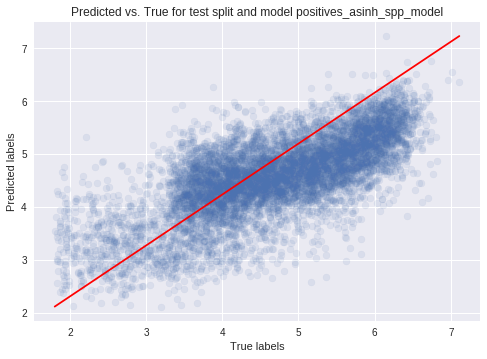

SpearmanrResult(correlation=0.6920744548449356, pvalue=0.0)
Model name binary_preact_model


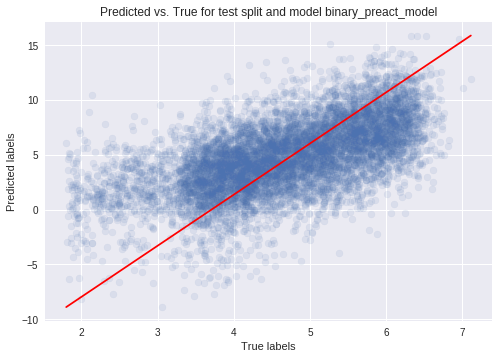

SpearmanrResult(correlation=0.6124985113616588, pvalue=0.0)
Split name valid
Model name positives_asinh_spp_model


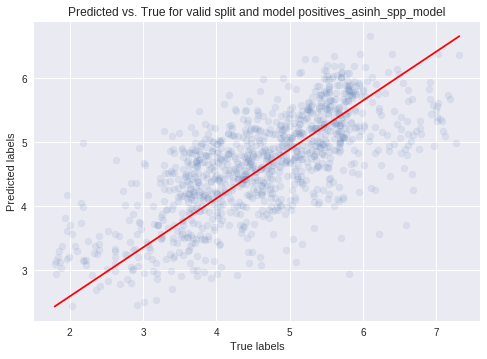

SpearmanrResult(correlation=0.6975606064295612, pvalue=1.5541488708536654e-158)
Model name binary_preact_model


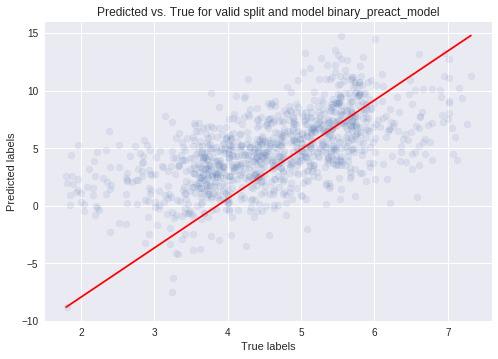

SpearmanrResult(correlation=0.6107991582300147, pvalue=1.243787995490186e-111)
Split name train
Model name positives_asinh_spp_model


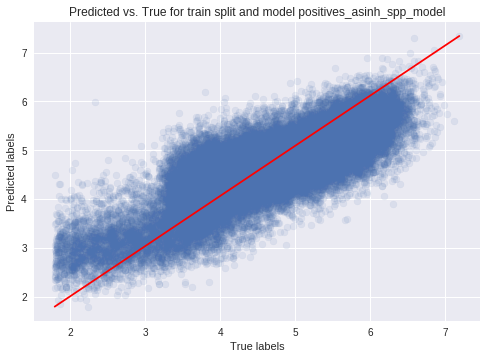

SpearmanrResult(correlation=0.772522661131623, pvalue=0.0)
Model name binary_preact_model


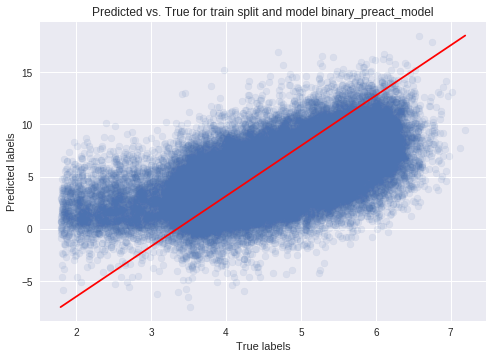

SpearmanrResult(correlation=0.5902630580644049, pvalue=0.0)


In [45]:
from scipy.stats import spearmanr
for split_name, split_labels, split_modelname_to_predictions in [
    ('test', test_positives_asinh_spp_y, test_positives_asinh_spp_name_to_predictions),
    ('valid', valid_positives_asinh_spp_y, valid_positives_asinh_spp_name_to_predictions),
    ('train', train_positives_asinh_spp_y, train_positives_asinh_spp_name_to_predictions)
]:
  print("Split name",split_name)
  for modelname in split_modelname_to_predictions:
    print("Model name",modelname)
    plt.scatter(split_labels[:,0],
                split_modelname_to_predictions[modelname][:,0], alpha=0.1)
    plt.xlabel("True labels")
    plt.ylabel("Predicted labels")
    plt.title("Predicted vs. True for "+split_name+" split"+" and model "+modelname)
    plt.plot([np.min(split_labels), np.max(split_labels)],
             [np.min(split_modelname_to_predictions[modelname][:,0]),
              np.max(split_modelname_to_predictions[modelname][:,0])],
             color="red")
    plt.show()
    print(spearmanr(a=split_labels[:,0],
                    b=split_modelname_to_predictions[modelname][:,0]))

In [0]:
from scipy.stats import spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score

binary_name_to_model = {'positives_asinh_spp_model': positives_asinh_spp_model,
                        'binary_preact': binary_preact_model}

test_binary_y, test_binary_name_to_predictions = get_predictions_and_true_labels(
    bed_source="test_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[0],
    name_to_model=binary_name_to_model)
valid_binary_y, valid_binary_name_to_predictions = get_predictions_and_true_labels(
    bed_source="valid_hybridbnc_asinh_spp_labels.gz",
    labels_subset=[0],
    name_to_model=binary_name_to_model)

for split_name, split_labels, split_modelname_to_predictions in [
    ('test', test_binary_y, test_binary_name_to_predictions),
    ('valid', valid_binary_y, valid_binary_name_to_predictions)
]:
  print("\nSplit name",split_name)
  print("Proportion of positives:",np.sum(split_labels)/len(split_labels))
  print("auROC")
  for modelname in split_modelname_to_predictions:
    print(modelname,
      roc_auc_score(y_true=split_labels[:,0],
                    y_score=split_modelname_to_predictions[modelname][:,0]))
  print("auPRC")
  for modelname in split_modelname_to_predictions:
    print(modelname,
      average_precision_score(y_true=split_labels[:,0],
                              y_score=split_modelname_to_predictions[modelname][:,0]))





Reading bed file test_hybridbnc_asinh_spp_labels.gz into memory
Finished reading bed file into memory; got 439596rows


In [0]:
from matplotlib import pyplot as plt
import seaborn as sns

hb = plt.hexbin(test_binary_name_to_predictions['binary_preact'][test_binary_name_to_predictions['binary_preact'] > -7],
           test_binary_name_to_predictions['positives_asinh_spp_model'][test_binary_name_to_predictions['binary_preact'] > -7],
           C=test_binary_y[test_binary_name_to_predictions['binary_preact'] > -7],
           reduce_C_function=lambda x: np.sum(x)/len(x),
           mincnt=10,
           cmap="coolwarm",
           gridsize=30)
plt.colorbar(hb)
plt.xlim(-7,12)
plt.title("Probability of being positive")
plt.xlabel("Binary preact predictions")
plt.ylabel("Regression predictions")
plt.show()

hb = plt.hexbin(test_positives_asinh_spp_name_to_predictions['binary_preact_model'][:,0],
           test_positives_asinh_spp_name_to_predictions['positives_asinh_spp_model'][:,0],
           C=test_positives_asinh_spp_y[:,0],
           reduce_C_function=lambda x: np.mean(x),
           mincnt=10,
           cmap="coolwarm",
           gridsize=30)
plt.colorbar(hb)
plt.xlim(-7,12)
plt.title("Mean regression label")
plt.xlabel("Binary preact predictions")
plt.ylabel("Regression predictions")
plt.show()

In [0]:
from keras import backend as K

class HybridSpearmanCorrCallback(keras.callbacks.Callback):
    
    def __init__(self, validation_steps,
                       valid_data_generator):
      self.validation_steps = validation_steps
      self.valid_data_generator = valid_data_generator
  
    def on_epoch_end(self, epoch, logs):
      valid_data_preds = []
      valid_data_labels = []
      for batch_num in range(self.validation_steps):
        (X_batch, y_batch) = six.next(self.valid_data_generator)
        valid_data_labels.extend(y_batch["output"])
        valid_data_preds.extend(self.model.predict(X_batch))
      valid_data_preds = np.array(valid_data_preds)
      valid_data_labels = np.array(valid_data_labels)
      
      print(spearmanr(a=valid_data_labels[valid_data_labels[:,0]==1][:,1],
                      b=valid_data_preds[valid_data_labels[:,0]==1][:,1]))


def hybrid_loss(y_true,y_pred):
    #y_true and y_pred are structured as follows:
    #first dimension is sample,
    #second dimension has length 2; first entry in y_pred is the *logit*
    # of the sigmoid (we will put it through the sigmoid in the loss func and
    # then apply binary crossentropy)
    # second entry in y_pred is the predicted value for the regression (we
    # will apply a mean-squared error loss to this)

    binary_task_predicted_logits = y_pred[:,0:1]
    binary_y_true = y_true[:,0:1]
    regression_y_true = y_true[:,1:2]
    regression_task_predictions = y_pred[:,1:2]
    binary_task_crossentropy_loss = K.mean(K.binary_crossentropy(
        target=binary_y_true, output=binary_task_predicted_logits,
        from_logits=True),axis=-1)
    regression_weight = binary_y_true
    regression_loss = K.sum(K.square(regression_task_predictions -
                                      regression_y_true)*regression_weight,
                             axis=-1)
    
    return regression_loss#binary_task_crossentropy_loss + regression_loss

def train_hybridbnc_model(
    num_outputs,
    positives_train_bed_source,
    negatives_train_bed_source,
    positives_valid_bed_source,
    negatives_valid_bed_source,
    negatives_to_positives_ratio,
    num_validation_samples,
    steps_per_epoch=200,
    batch_size=128,
    adam_lr=0.001,
    num_conv_filters=15,
    conv_filter_length=15,
    pool_length_and_stride=5,
    num_dense_units=[100],
    preinit_model=None,
    epochs_to_train_for=60):
  
  validation_steps = int(np.ceil(num_validation_samples/batch_size))
  
  if (preinit_model is None):
    
    (input,dense1relu) = get_core_model(
        num_conv_filters=num_conv_filters,
        conv_filter_length=conv_filter_length,
        pool_length_and_stride=pool_length_and_stride,
        num_dense_units=num_dense_units)
    output = keras.layers.core.Dense(units=num_outputs,
                                     name="output")(dense1relu)
    #output = keras.layers.core.Activation("sigmoid", name="output")(output_preact)
    model = Model(inputs=[input], outputs=[output])
    model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                  loss={"output": hybrid_loss})
  else:
    model = preinit_model
  
  model.summary()
  early_stopping_callback = keras.callbacks.EarlyStopping(
                              monitor='val_loss',
                              patience=epochs_to_train_for,
                              restore_best_weights=True)
  fit_history = model.fit_generator(
    generator=get_two_stream_data_generator(
      positives_bed_source=positives_train_bed_source,
      negatives_bed_source=negatives_train_bed_source,
      negatives_to_positives_ratio=negatives_to_positives_ratio,
      batch_size=batch_size).get_batch_generator(),
    validation_data=get_two_stream_data_generator(
      positives_bed_source=positives_valid_bed_source,
      negatives_bed_source=negatives_valid_bed_source,
      negatives_to_positives_ratio=negatives_to_positives_ratio,
      batch_size=batch_size).get_batch_generator(),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=epochs_to_train_for,
    callbacks=[early_stopping_callback,
               #Need to have two separate generators for the callback and
               # for the main training method to keep keras happy
               
               #BinaryClassificationCallback(
               #    valid_data_generator=get_two_stream_data_generator(
               #       positives_bed_source=positives_valid_bed_source,
               #       negatives_bed_source=negatives_valid_bed_source,
               #       negatives_to_positives_ratio=negatives_to_positives_ratio,
               #       batch_size=batch_size).get_batch_generator(),
               #    validation_steps=validation_steps,
               #    idx_to_look_at=0),
              HybridSpearmanCorrCallback(
                   valid_data_generator=get_two_stream_data_generator(
                      positives_bed_source=positives_valid_bed_source,
                      negatives_bed_source=negatives_valid_bed_source,
                      negatives_to_positives_ratio=negatives_to_positives_ratio,
                      batch_size=batch_size).get_batch_generator(),
                   validation_steps=validation_steps)
              ]
  )
  #the callback isn't triggered if the upper epoch limit is hit,
  # so make sure the set the weights from the best epoch at the end
  model.set_weights(early_stopping_callback.best_weights)
  
  return model, fit_history

In [17]:
hybridbnc_model, hybridbnc_fit_history = train_hybridbnc_model(
         adam_lr=0.001,
         num_outputs=2,
         num_validation_samples=5000,
         negatives_to_positives_ratio=1,
         positives_train_bed_source="positives_train_hybridbnc_asinh_spp_labels.gz",
         negatives_train_bed_source="negatives_train_hybridbnc_asinh_spp_labels.gz",
         positives_valid_bed_source="positives_valid_hybridbnc_asinh_spp_labels.gz",
         negatives_valid_bed_source="negatives_valid_hybridbnc_asinh_spp_labels.gz",
         )

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 1000, 15)          915       
_________________________________________________________________
activation_25 (Activation)   (None, 1000, 15)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 1000, 15)          3390      
_________________________________________________________________
activation_26 (Activation)   (None, 1000, 15)          0         
_________________________________________________________________
conv1d_21 (Conv1D)           (None, 1000, 15)          3390      
_________________________________________________________________
activation_27 (Activation)   (None, 1000, 15)          0         
__________

In [109]:
#Save the model
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd /content/gdrive/"My Drive"/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
#hybridbnc_model.save("hybridbnc_model_2018Nov29_1020pm.h5")
#%cd /content

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive/colab_notebook_data/regression_experiments/K562/CTCF/ENCFF519CXF
/content


Best val epoch 24


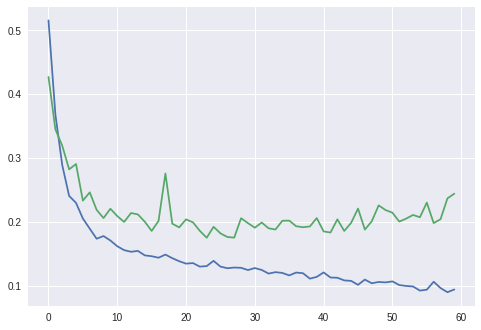

In [114]:
print("Best val epoch",np.argmin(hybridbnc_fit_history.history['val_loss'])+1)
plt.plot(list(range(len(hybridbnc_fit_history.history['loss']))),
         hybridbnc_fit_history.history['loss'])
plt.plot(list(range(len(hybridbnc_fit_history.history['val_loss']))),
         hybridbnc_fit_history.history['val_loss'])